In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install patchify albumentations[imgaug] scikit-image
# if you will write COCO later:
!pip install pycocotools
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4d_6vjr4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4d_6vjr4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=4618308f16fea299b45f939a09ca905dc6f1092d5b11e287fb9de5f71945f7ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-jpyl3xl5/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.6/515.6 kB 15.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take

  ERROR: Operation cancelled by user
^C


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the pre-trained model

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/demo_model_checkpoint.pth"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

# Load the image and make it into chunks

In [ ]:
large_test_images = tifffile.imread("/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/testing.tif")
large_test_image  = large_test_images[1]          # (H, W)

large_test_masks = tifffile.imread("/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/testing_groundtruth.tif")
large_test_mask  = large_test_masks[1]          # (H, W)


print(f"large_test_image shape : {large_test_image.shape}")
print(f"large_test_mask shape : {large_test_mask.shape}")


large_test_image shape : (768, 1024)
large_test_mask shape : (768, 1024)


large_test_image shape : (768, 1024)
large_test_mask shape  : (768, 1024)


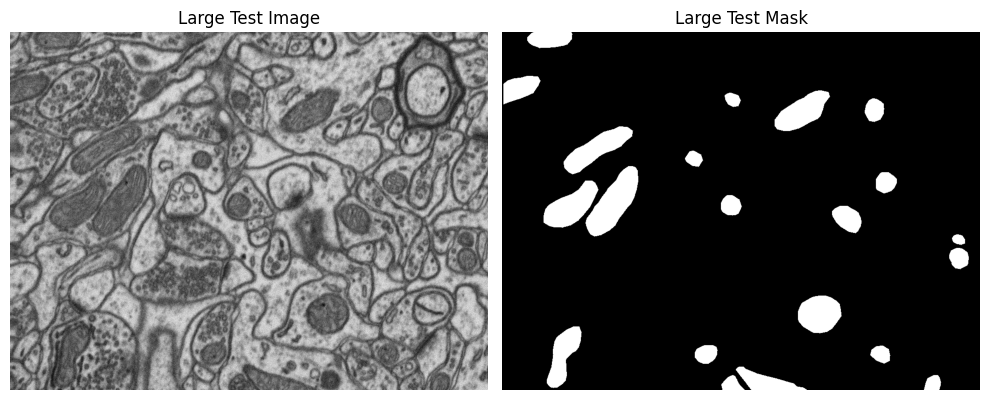

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(f"large_test_image shape : {large_test_image.shape}")
print(f"large_test_mask shape  : {large_test_mask.shape}")

plt.figure(figsize=(10, 4))

# Left: image
plt.subplot(1, 2, 1)
plt.imshow(large_test_image, cmap='gray')
plt.title('Large Test Image')
plt.axis('off')

# Right: mask
plt.subplot(1, 2, 2)
plt.imshow(large_test_mask, cmap='gray')
plt.title('Large Test Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

def _get_starts(L, patch_size, step):
    """
    Compute valid starting indices along one dimension (0..L-1)
    so that all patches are fully inside the image, and the last
    patch touches the border. This may create extra overlap at the end.
    """
    # If image is smaller than a patch, just start at 0
    if L <= patch_size:
        return [0]

    # Regular starts with fixed step, staying inside bounds
    starts = list(range(0, L - patch_size + 1, step))

    # Ensure we also have a patch that ends exactly at L
    last_start = L - patch_size
    if last_start not in starts:
        starts.append(last_start)

    return sorted(starts)

def chunk_image_with_overlap(image, chunk_size, overlap):
    """
    Split image into overlapping square chunks, covering the full image
    without padding by increasing overlap at the borders.

    Args:
        image: np.array, shape (H, W) or (H, W, C)
        chunk_size: int, patch size (height and width)
        overlap: int, number of pixels overlapping between adjacent chunks

    Returns:
        chunks: list of np.array patches, each (chunk_size, chunk_size) or (chunk_size, chunk_size, C)
        chunk_coords: list of (y, x) top-left coordinates for each chunk in the original image
    """
    H, W = image.shape[:2]
    step = chunk_size - overlap

    y_starts = _get_starts(H, chunk_size, step)
    x_starts = _get_starts(W, chunk_size, step)

    chunks = []
    chunk_coords = []

    for y in y_starts:
        for x in x_starts:
            chunk = image[y:y+chunk_size, x:x+chunk_size]
            chunks.append(chunk)
            chunk_coords.append((y, x))  # (row, col)

    return chunks, chunk_coords


In [ ]:
chunk_size = 256
overlap    = 32

chunks, chunk_coords = chunk_image_with_overlap(large_test_image, chunk_size, overlap)
print("num chunks:", len(chunks))
print("first coord:", chunk_coords[0])
print("first chunk shape:", chunks[0].shape)


num chunks: 20
first coord: (0, 0)
first chunk shape: (256, 256)


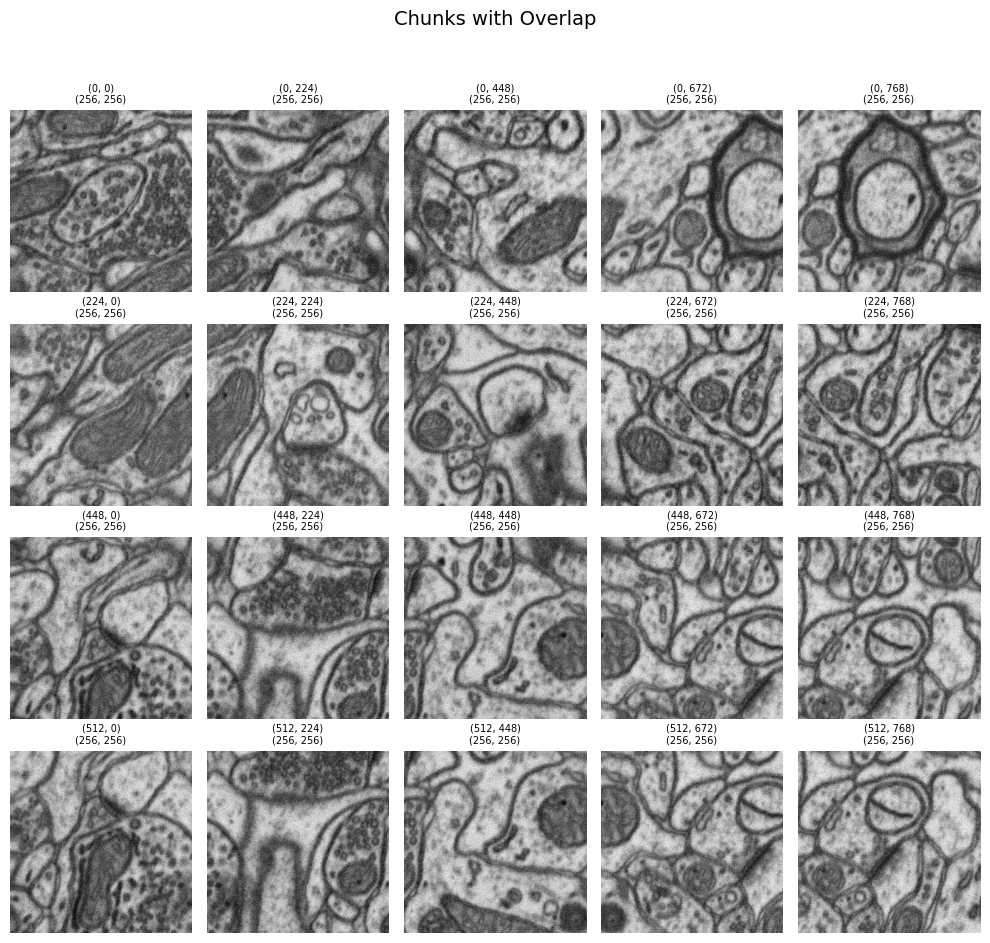

In [ ]:
num_chunks = len(chunks)
ncols = int(np.ceil(np.sqrt(num_chunks)))
nrows = int(np.ceil(num_chunks / ncols))

plt.figure(figsize=(10, 10))
plt.suptitle('Chunks with Overlap', fontsize=14)

for i, (chunk, (y_start, x_start)) in enumerate(zip(chunks, chunk_coords)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(chunk, cmap='gray' if chunk.ndim == 2 else None)
    plt.title(f"({y_start}, {x_start})\n{chunk.shape}", fontsize=7)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# predict segmented mask

### Create Grid of 10x10 for teh promt in input image


In [ ]:
def make_grid_promts(array_size = 256, grid_size = 10):
  # Generate the grid points
  x = np.linspace(0, array_size-1, grid_size)
  y = np.linspace(0, array_size-1, grid_size)

  # Generate a grid of coordinates
  xv, yv = np.meshgrid(x, y)

  # Convert the numpy arrays to lists
  xv_list = xv.tolist()
  yv_list = yv.tolist()

  # Combine the x and y coordinates into a list of list of lists
  input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
  input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

  return input_points


In [ ]:
make_grid_promts().shape

torch.Size([1, 1, 100, 2])

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

def predict_patch_sam(
    patch,
    input_points=None,
    threshold=0.5,
    visualize=False,
):
    """
    Run SAM-based model on a single 2D patch.

    Args:
        patch        : numpy array or PIL.Image (256x256)
        input_points : SAM point prompts tensor or None.
                       If None -> no point prompts (just image).
        threshold    : probability threshold for binary mask.
        visualize    : if True, plot image, prob map, prediction.

    Returns:
        pred_mask : np.uint8 (H, W) {0,1}
        prob_map  : np.float32 (H, W) in [0,1]
    """
    # Ensure PIL image for processor
    if isinstance(patch, np.ndarray):
        single_patch = Image.fromarray(patch)
    else:
        single_patch = patch

    # Prepare inputs for the model
    if input_points is None:
        inputs = processor(single_patch, return_tensors="pt")
    else:
        # Convert input_points tensor to a list if it's a tensor, and reshape it
        if isinstance(input_points, torch.Tensor):
            # Squeeze the second dimension to get shape [1, N, 2] before converting to list
            input_points = input_points.squeeze(1).tolist()
        inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # outputs.pred_masks: (B,1,H,W)
    prob_t = torch.sigmoid(outputs.pred_masks.squeeze(1))  # (B,H,W)
    prob_map = prob_t.cpu().numpy().squeeze().astype(np.float32)  # (H,W)

    pred_mask = (prob_map > threshold).astype(np.uint8)

    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(np.array(single_patch), cmap='gray')
        axes[0].set_title("Image")
        axes[0].axis('off')

        im1 = axes[1].imshow(prob_map, cmap='viridis')
        axes[1].set_title("Probability Map")
        axes[1].axis('off')
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title(f"Prediction (thr={threshold})")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    return pred_mask, prob_map

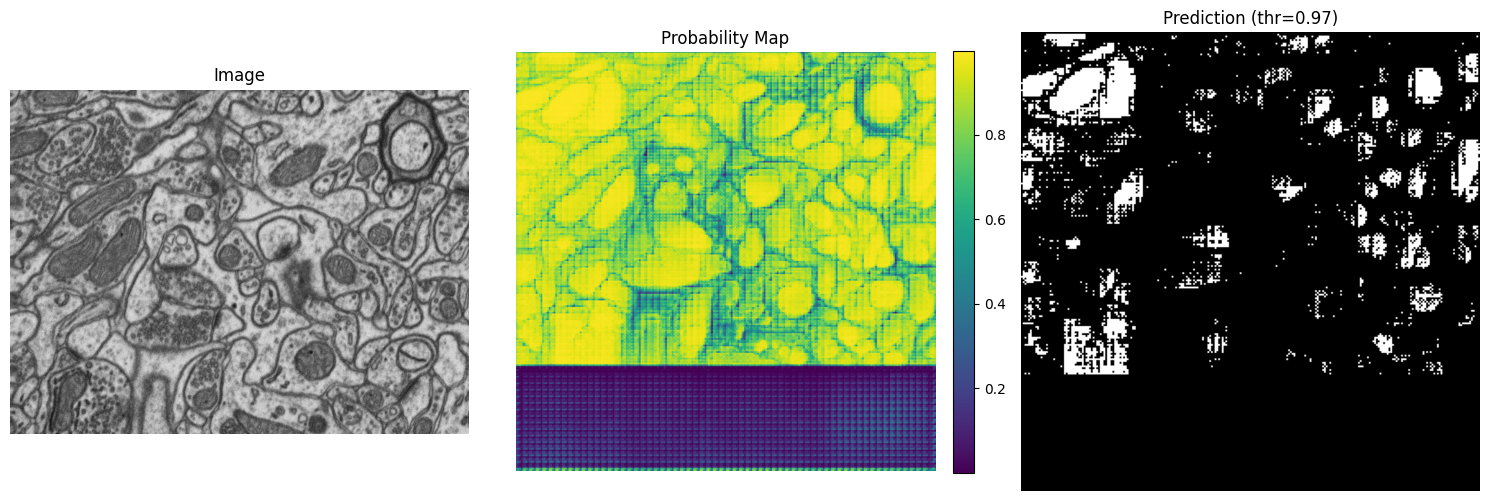

In [ ]:
# Pick a specific patch
# The previous 'chunk' variable in kernel state refers to the last chunk processed in the visualization loop.
# Indexing it as chunk[i, j] results in a single pixel value (e.g., 140), not an image patch.
# To select an actual image patch, we should use the 'chunks' list.

# For example, let's pick the first chunk from the 'chunks' list:
patch_to_process = large_test_image

pred_mask_list = []
all_prob_maps = [] # Renamed to avoid conflict


# for i in range(0, len(chunks)):

#   current_pred_mask , current_prob_map = predict_patch_sam( # Use temporary variables for current output
#       patch= chunks[i],
#       input_points=make_grid_promts(),   # or None to test no prompts make_grid_promts()
#       threshold=0.7,
#       visualize=True,              # show the 3-panel plot
#   )
  # pred_mask_list.append(current_pred_mask)
  # all_prob_maps.append(current_prob_map) # Append to the collecting list


# checking on full image
current_pred_mask , current_prob_map = predict_patch_sam( # Use temporary variables for current output
      patch= patch_to_process,
      input_points=make_grid_promts(1024),   # or None to test no prompts make_grid_promts()
      threshold=0.97,
      visualize=True,              # show the 3-panel plot
  )

# Merge the preditions

In [ ]:
import numpy as np

def make_hann_window(patch_shape):
    """
    Create a 2D Hann window for a 2D patch of shape (ph, pw).
    """
    ph, pw = patch_shape
    wy = np.hanning(ph)          # (ph,)
    wx = np.hanning(pw)          # (pw,)
    hann2d = np.outer(wy, wx)    # (ph, pw)
    return hann2d.astype(np.float32)


def stitch_chunks_hann(chunks, chunk_coords, full_shape):
    """
    Stitch 2D chunks back into a full image using a 2D Hann window
    for smooth merging in overlapping regions.

    chunks       : list of 2D arrays (patches)
    chunk_coords : list of (y_start, x_start) top-left coords
    full_shape   : (H, W) of original image
    """
    H, W = full_shape
    final_image = np.zeros((H, W), dtype=np.float32)
    weight      = np.zeros((H, W), dtype=np.float32)

    # Assume all patches have same shape as first
    first_patch = np.asarray(chunks[0])
    ph, pw = first_patch.shape

    hann2d = make_hann_window((ph, pw))

    for patch, (y_start, x_start) in zip(chunks, chunk_coords):
        patch = np.asarray(patch).astype(np.float32)
        h, w = patch.shape

        y_end = min(y_start + h, H)
        x_end = min(x_start + w, W)

        if y_end > y_start and x_end > x_start:
            hh = y_end - y_start
            ww = x_end - x_start

            w_local = hann2d[:hh, :ww]
            final_image[y_start:y_end, x_start:x_end] += patch[:hh, :ww] * w_local
            weight[y_start:y_end, x_start:x_end]      += w_local

    # avoid division by zero
    weight[weight == 0] = 1.0
    final_image = final_image / weight

    return final_image



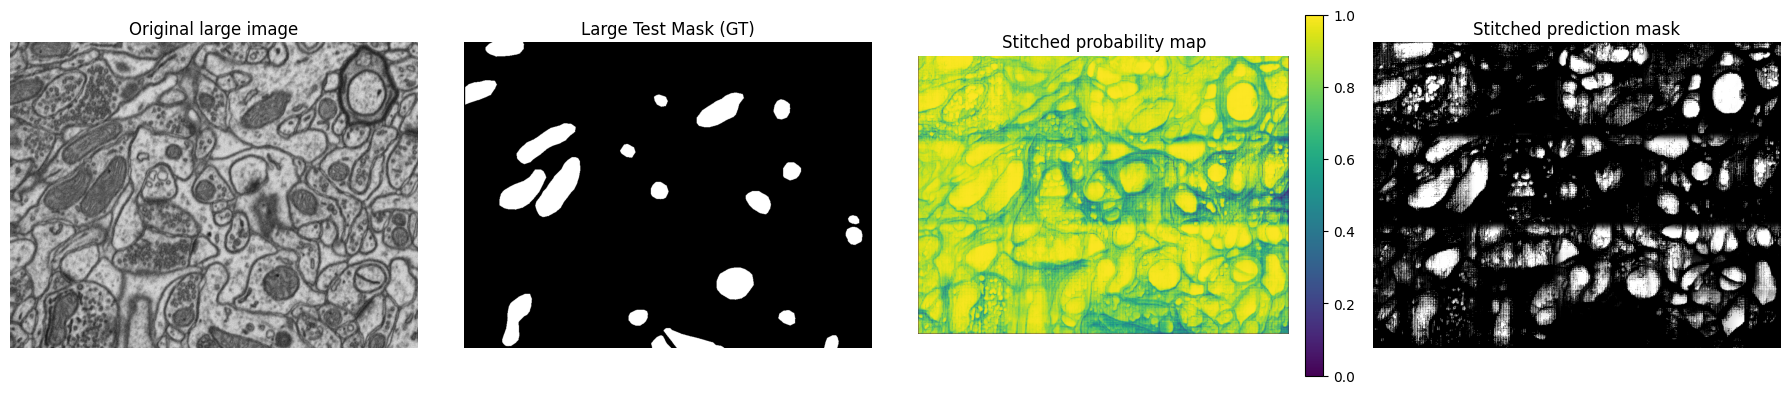

In [ ]:
full_shape = large_test_image.shape  # (768, 1024)

stitched_mask = stitch_chunks_hann(pred_mask_list, chunk_coords, full_shape)
stitched_prob = stitch_chunks_hann(all_prob_maps,  chunk_coords, full_shape)

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# 1) Original image
axes[0].imshow(large_test_image, cmap='gray')
axes[0].set_title("Original large image")
axes[0].axis('off')

# 2) Ground truth mask
axes[1].imshow(large_test_mask, cmap='gray')
axes[1].set_title("Large Test Mask (GT)")
axes[1].axis('off')

# 3) Stitched probability map
im = axes[2].imshow(stitched_prob, cmap='viridis', vmin=0, vmax=1)
axes[2].set_title("Stitched probability map")
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], fraction=0.05, pad=0.04)

# 4) Stitched binary mask
axes[3].imshow(stitched_mask, cmap='gray')
axes[3].set_title("Stitched prediction mask")
axes[3].axis('off')

plt.tight_layout()
plt.show()
